In [1]:
import numpy as np
from scipy.optimize import curve_fit
import scipy.odr as odr
import pandas as pd
from uncertainties import ufloat, unumpy
import seaborn as sns
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

from lmfit.models import ConstantModel, LinearModel, PolynomialModel

In [2]:
# To use LaTeX and select Helvetica as the default font, without editing matplotlibrc use:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{physics}')
plt.rc('font', family='serif')

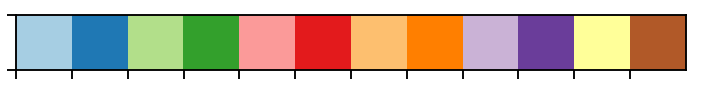

In [3]:
sns.set_context('talk')
sns.palplot(sns.color_palette("Paired"))

# Constants

In [4]:
C = 299792458 # Speed of light [m Hz]

AMU = ufloat(1.66053906660, 0.00000000050)*1E-27 # [kg]

I_S_OFFSET = 45932
MASS_OFFSET = 84

In [5]:
data = {'isotope': [88, 87, 86, 84],
        'mass'   : [ufloat(87.9056125, 0.0000012),
                    ufloat(86.9088775, 0.0000012),
                    ufloat(85.9092606, 0.0000012),
                    ufloat(83.9134191, 0.0000013)],
        'I_S'    : [ufloat(45932.1982, 0.0010),
                    ufloat(45932.2861, 0.0010),
                    ufloat(45932.1912, 0.0010),
                    ufloat(45932.1833, 0.0010)]}

data = pd.DataFrame(data)
data

,isotope,mass,I_S
0,88,87.9056125+/-0.0000012,45932.1982+/-0.0010
1,87,86.9088775+/-0.0000012,45932.2861+/-0.0010
2,86,85.9092606+/-0.0000012,45932.1912+/-0.0010
3,84,83.9134191+/-0.0000013,45932.1833+/-0.0010


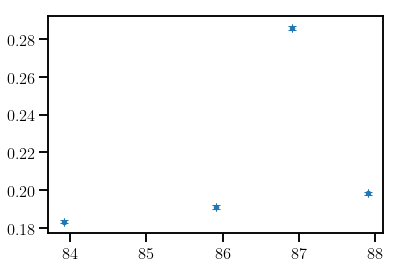

In [6]:
plt.figure()

xdata = unumpy.nominal_values(data['mass'])
xdata_err = unumpy.std_devs(data['mass'])
ydata = unumpy.nominal_values(data['I_S']) - I_S_OFFSET
ydata_err = unumpy.std_devs(data['I_S'])

plt.errorbar(xdata, ydata, xerr=xdata_err, yerr=ydata_err, fmt='.', capsize=4)

plt.show()

# Mass-scaled ionization limit of 87Sr

[[Model]]
    Model(linear, prefix='l_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 3
    # variables        = 2
    chi-square         = 1.3557e-07
    reduced chi-square = 1.3557e-07
    Akaike info crit   = -46.7371237
    Bayesian info crit = -48.5398991
[[Variables]]
    l_intercept:  0.18377348 +/- 3.2744e-04 (0.18%) (init = 0.24)
    l_slope:      0.00373227 +/- 1.3043e-04 (3.49%) (init = 0.005)
[[Correlations]] (unreported correlations are < 0.100)
    C(l_intercept, l_slope) = -0.761



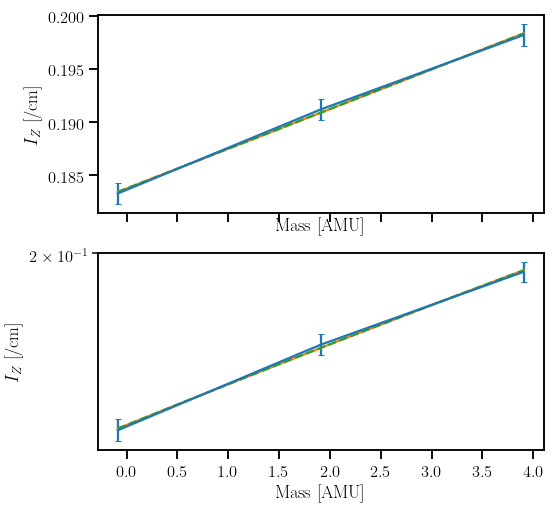

In [7]:
# Plotting options
plot_components = True
plot_initial_guess = False

# Drop 87Sr data from fitting
fit_data = data.drop([1], axis=0)

# Arrays used for fitting
xdata = unumpy.nominal_values(fit_data['mass']) - MASS_OFFSET
xdata_unc = unumpy.std_devs(fit_data['mass'])
ydata = unumpy.nominal_values(fit_data['I_S']) - I_S_OFFSET
ydata_unc = unumpy.std_devs(fit_data['I_S'])

# Specify fit model
mass = LinearModel(prefix='l_')

fit_model = mass
fit_params = fit_model.make_params()

fit_params['l_slope'].set(0.005, vary=True)
fit_params['l_intercept'].set(0.24, vary=True)

# Initial guess
xfit = np.linspace(min(xdata), max(xdata), num=1000, endpoint=True)
yinit = fit_model.eval(fit_params, x=xfit)

# Fitting
fit_result = fit_model.fit(ydata, fit_params, x=xdata)
dely = fit_result.eval_uncertainty(x=xdata)
yfit = fit_model.eval(fit_result.params, x=xfit)

print(fit_result.fit_report())

# Plotting output
[fig, axs] = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

axs[0].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[0].plot(xfit, yfit, label='fit')
axs[0].set_xlabel(r'Mass [AMU]')
axs[0].set_ylabel(r'$I_Z$ [/cm]')

axs[1].set_yscale('log')
axs[1].errorbar(xdata, ydata, yerr=ydata_unc, capsize=3, label='data')
axs[1].plot(xfit, yfit, label='fit')
axs[1].set_xlabel(r'Mass [AMU]')
axs[1].set_ylabel(r'$I_Z$ [/cm]')

if plot_components:
    # generate components
    fit_comps = fit_result.eval_components(x=xfit)
    
    for key in fit_comps.keys():
        for ax in axs:
            ax.plot(xfit, fit_comps[key], '--')

if plot_initial_guess:
    for ax in axs:
        ax.plot(xfit, yinit, '-.', label='init')

plt.show()

In [8]:
fit_slope = ufloat(fit_result.params['l_slope'].value, fit_result.params['l_slope'].stderr)
fit_intercept = ufloat(fit_result.params['l_intercept'].value, fit_result.params['l_intercept'].stderr)

def fitted_mass_scaling(mass):
    return (mass-MASS_OFFSET)*fit_slope + fit_intercept

# Plotting ionization limits and fitted result

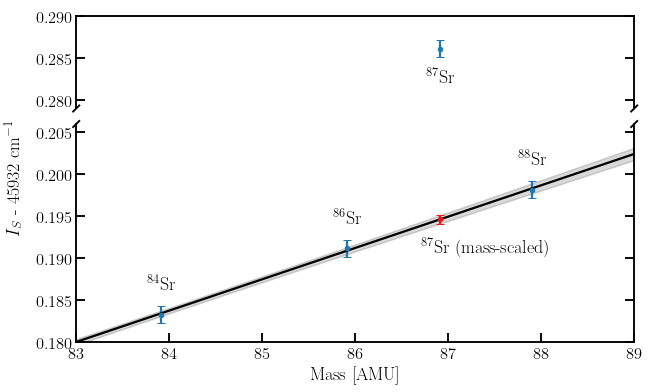

In [32]:
# Plot bounds
[xmin, xmax] = [83, 89]

# Calculate mass-scalied ionization energies
xfit = np.linspace(xmin, xmax, endpoint=True)
yfit = fitted_mass_scaling(xfit)
yfit_unc = unumpy.std_devs(yfit)
yfit = unumpy.nominal_values(yfit)

# Data points
xdata = unumpy.nominal_values(data['mass'])
xdata_unc = unumpy.std_devs(data['mass'])
ydata = unumpy.nominal_values(data['I_S']) - I_S_OFFSET
ydata_unc = unumpy.std_devs(data['I_S'])

# Mass-scaled ionization limit for 87Sr
M87 = data[data['isotope'] == 87]['mass']
I_S_87 = fitted_mass_scaling(M87)

bax_kwargs = {'d':0.006,
              'wspace':0.05,
              'despine':False}

fig = plt.figure(figsize=(10,6), frameon=True)
bax = brokenaxes(ylims=((0.180, 0.205+0.001), (0.280-0.001, 0.290)), hspace=0.1, fig=fig, **bax_kwargs)

bax.errorbar(xdata, ydata, xerr=xdata_unc, yerr=ydata_err, fmt='.', capsize=4,
             color=sns.color_palette("Paired")[1])
bax.errorbar(unumpy.nominal_values(M87), unumpy.nominal_values(I_S_87),
             xerr=unumpy.std_devs(M87), yerr=unumpy.std_devs(I_S_87), fmt='.', capsize=4,
             color=sns.color_palette("Paired")[5])

bax.plot(unumpy.nominal_values(xfit), unumpy.nominal_values(yfit), color='black')
bax.fill_between(xfit, yfit+yfit_unc, yfit-yfit_unc, alpha=0.15, color='black')

# Label points
TEXT_OFFSET = 0.0035
bax.axs[1].annotate(s=r'${}^{84}\text{Sr}$',
                    xy=(unumpy.nominal_values(data[data['isotope']==84]['mass']),
                        unumpy.nominal_values(data[data['isotope']==84]['I_S']) -I_S_OFFSET + TEXT_OFFSET),
                    ha='center', va='center')

bax.axs[1].annotate(s=r'${}^{86}\text{Sr}$',
                    xy=(unumpy.nominal_values(data[data['isotope']==86]['mass']),
                        unumpy.nominal_values(data[data['isotope']==86]['I_S'])-I_S_OFFSET + TEXT_OFFSET),
                    ha='center', va='center')

bax.axs[0].annotate(s=r'${}^{87}\text{Sr}$',
                    xy=(unumpy.nominal_values(data[data['isotope']==87]['mass']),
                        unumpy.nominal_values(data[data['isotope']==87]['I_S'])-I_S_OFFSET - TEXT_OFFSET),
                    ha='center', va='center')

bax.axs[1].annotate(s=r'${}^{87}\text{Sr}$ (mass-scaled)',
                    xy=(unumpy.nominal_values(data[data['isotope']==87]['mass'] - 0.2),
                        unumpy.nominal_values(I_S_87) - TEXT_OFFSET),
                    ha='left', va='center')

bax.axs[1].annotate(s=r'${}^{88}\text{Sr}$',
                    xy=(unumpy.nominal_values(data[data['isotope']==88]['mass']),
                        unumpy.nominal_values(data[data['isotope']==88]['I_S'])-I_S_OFFSET + TEXT_OFFSET),
                    ha='center', va='center')

bax.set_xlim((xmin, xmax))

bax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True, direction='in')
bax.axs[0].tick_params(axis='both', which='both', bottom=False, top=True, left=True, right=True, direction='in')
bax.axs[1].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=True, direction='in')

#bax.set_xlabel(r'Mass [AMU]', labelpad=50, ha='center', va='center')
bax.axs[1].set_xlabel(r'Mass [AMU]', ha='center')
bax.set_ylabel(r'$I_{S}$ - ' + str(I_S_OFFSET) + ' ' + r'$\text{cm}^{-1}$', labelpad=60, va='center')

plt.savefig('Eion-mass-scaled.svg', bbox_inches='tight')

plt.show()

In [31]:
M87 = data[data['isotope'] == 87]['mass']
I_S_87 = fitted_mass_scaling(M87)
print(I_S_87 + I_S_OFFSET)

1    45932.1946+/-0.0005
Name: mass, dtype: object


# Old code

In [42]:
# Plot of ionization energy vs. mass

def fit_func(p, x):
    m, b = p
    return m*x + b

def perform_odr(x, y, xerr, yerr):
    """Finds the ODR for data {x, y} and returns the result"""
    
    odr_model = odr.Model(fit_func)
    
    mydata = odr.RealData(x, y, sx=xerr, sy=yerr)
    myodr = odr.ODR(mydata, odr_model, beta0=[0,1])
    
    output = myodr.run()
    
    return output

In [43]:
x = [83.9134191, 85.9092606, 87.9056125]
xerr = [0.0000013, 0.0000012, 0.0000012]
y = [45932.1833, 45932.1912, 45932.1982]
yerr = [0.0010, 0.0010, 0.0010]

regression = perform_odr(x, y, xerr, yerr)

In [46]:
m = regression.beta[0]
b = regression.beta[1]
fit_func([m, b], 86.9088775)
regression.pprint()

Beta: [3.73227462e-03 4.59318703e+04]
Beta Std Error: [0.00013355 0.0114577 ]
Beta Covariance: [[ 1.31563928e-07 -1.12851177e-05]
 [-1.12851177e-05  9.68333333e-04]]
Residual Variance: 0.13557209173285947
Inverse Condition #: 0.0019406477675623182
Reason(s) for Halting:
  Sum of squares convergence


it parameter 1-sigma error
———————————–
0.003732274293241976 +- 0.00013043325240102405
0.19870257793121637 +- 0.00034575258455909195


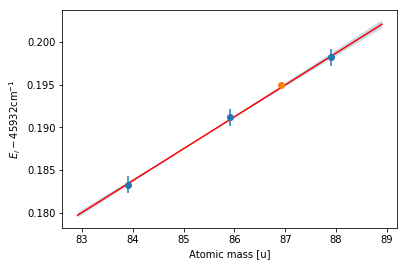

45932.19870+/-0.00035


In [13]:
# Plot of ionization energy vs. mass

def func(p, x):
    m, b = p
    return m*x + b

data = pd.DataFrame({'isotope' : [84, 86, 88],
                     'm'       : [83.9134191, 85.9092606, 87.9056125],
                     'dm'      : [0.0000013, 0.0000012, 0.0000012],
                     'Eion'    : [45932.1833, 45932.1912, 45932.1982],
                     'dEion'   : [0.0010, 0.0010, 0.0010]})
offset = 45932
mass_offset = 88
x = data.m - mass_offset
dx = data.dm
y = data.Eion-offset
dy = data.dEion

lin_model = odr.Model(func)
data = odr.RealData(x, y, sx=dx, sy=dy)

odrfit = odr.ODR(data, lin_model, beta0=[0.004, -0.13])
out = odrfit.run()

#print fit parameters and 1-sigma estimates
popt = out.beta
perr = out.sd_beta
print('it parameter 1-sigma error')
print('———————————–')
for i in range(len(popt)):
    print(str(popt[i])+' +- '+str(perr[i]))

# prepare confidence level curves
nstd = 1. # to draw 5-sigma intervals
popt_up = popt + nstd * perr
popt_dw = popt - nstd * perr

x_fit = np.linspace(min(x)-1, max(x)+1, 100)
y_fit = func(popt, x_fit)
fit_up = func(popt_up, x_fit)
fit_dw = func(popt_dw, x_fit)

fig, ax = plt.subplots(1)

plt.errorbar(x + mass_offset, y, xerr=dx, yerr = dy, fmt='o')
plt.plot(x_fit + mass_offset, y_fit, 'r')
ax.fill_between(x_fit + mass_offset, fit_up, fit_dw, alpha=.25, label='5-sigma interval')
plt.xlabel('Atomic mass [u]')
plt.ylabel(r'$E_i - 45932\rm{cm^{-1}}$')

plt.errorbar(86.9088775, 45932.19497-offset, xerr=0.0000012, yerr = 0.00022, fmt='o')

plt.savefig('Eion-mass-scaled.svg', bbox_inches='tight')
plt.show()

print(ufloat(0.19870257793121637+offset,0.00034575258455909195))

In [205]:
Ei87 = 45932 + func(popt, -1)
Ei87up = 45932 + func(popt_up, -1) - Ei87
Ei87dw = 45932 + func(popt_dw, -1) - Ei87

print('E_i for 87Sr: ' + str(Ei87))
print('+ ' + str(Ei87up))
print('- ' + str(Ei87dw))
print(ufloat(Ei87, Ei87up))

E_i for 87Sr: 45932.19497030364
+ 0.00021531933452934027
- -0.00021531933452934027
45932.19497+/-0.00022


In [222]:
# Ionization limit by subtracting F=4 HF shift from reported values
SoL = 299792458                  #[m/s] speed of light

Ei87 = ufloat(45932.2861,0.0010) #[/cm]
A = ufloat(-1000473.673,0.011)   #[/kHz] 87Sr hyperfine constant for 5s
A = A*(10)/SoL
S = 1/2
F = 4
I = 9/2
EF4 = (A/2)*(F*(F+1) - I*(I+1) - S*(S+1))
print(Ei87)
print(Ei87 - EF4)

45932.2861+/-0.0010
45932.1943+/-0.0010
